# Load Dataset

In [3]:
# Load dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data of image
images = np.load('datasets/ps4_trainvalid_images.npy')

# Load data of label 
labels = pd.read_csv('datasets/ps4_trainvalid_labels.csv', index_col=0)

In [6]:
import PIL

In [2]:
images.shape

(13260, 64, 64, 1)

In [12]:
images[0].shape

(64, 64, 1)

In [22]:
image0 = images[0].reshape(64,64)
image0

array([[  2,   2,   2, ...,   1,  48,   0],
       [  2,   2,   2, ...,   1,  13,  40],
       [  2,   2,   2, ...,   1,   1,   1],
       ...,
       [ 87, 122, 149, ...,  87,  40,   2],
       [ 86, 118, 145, ...,  76,  29,   1],
       [ 90, 124, 148, ...,  65,  14,   2]], dtype=uint8)

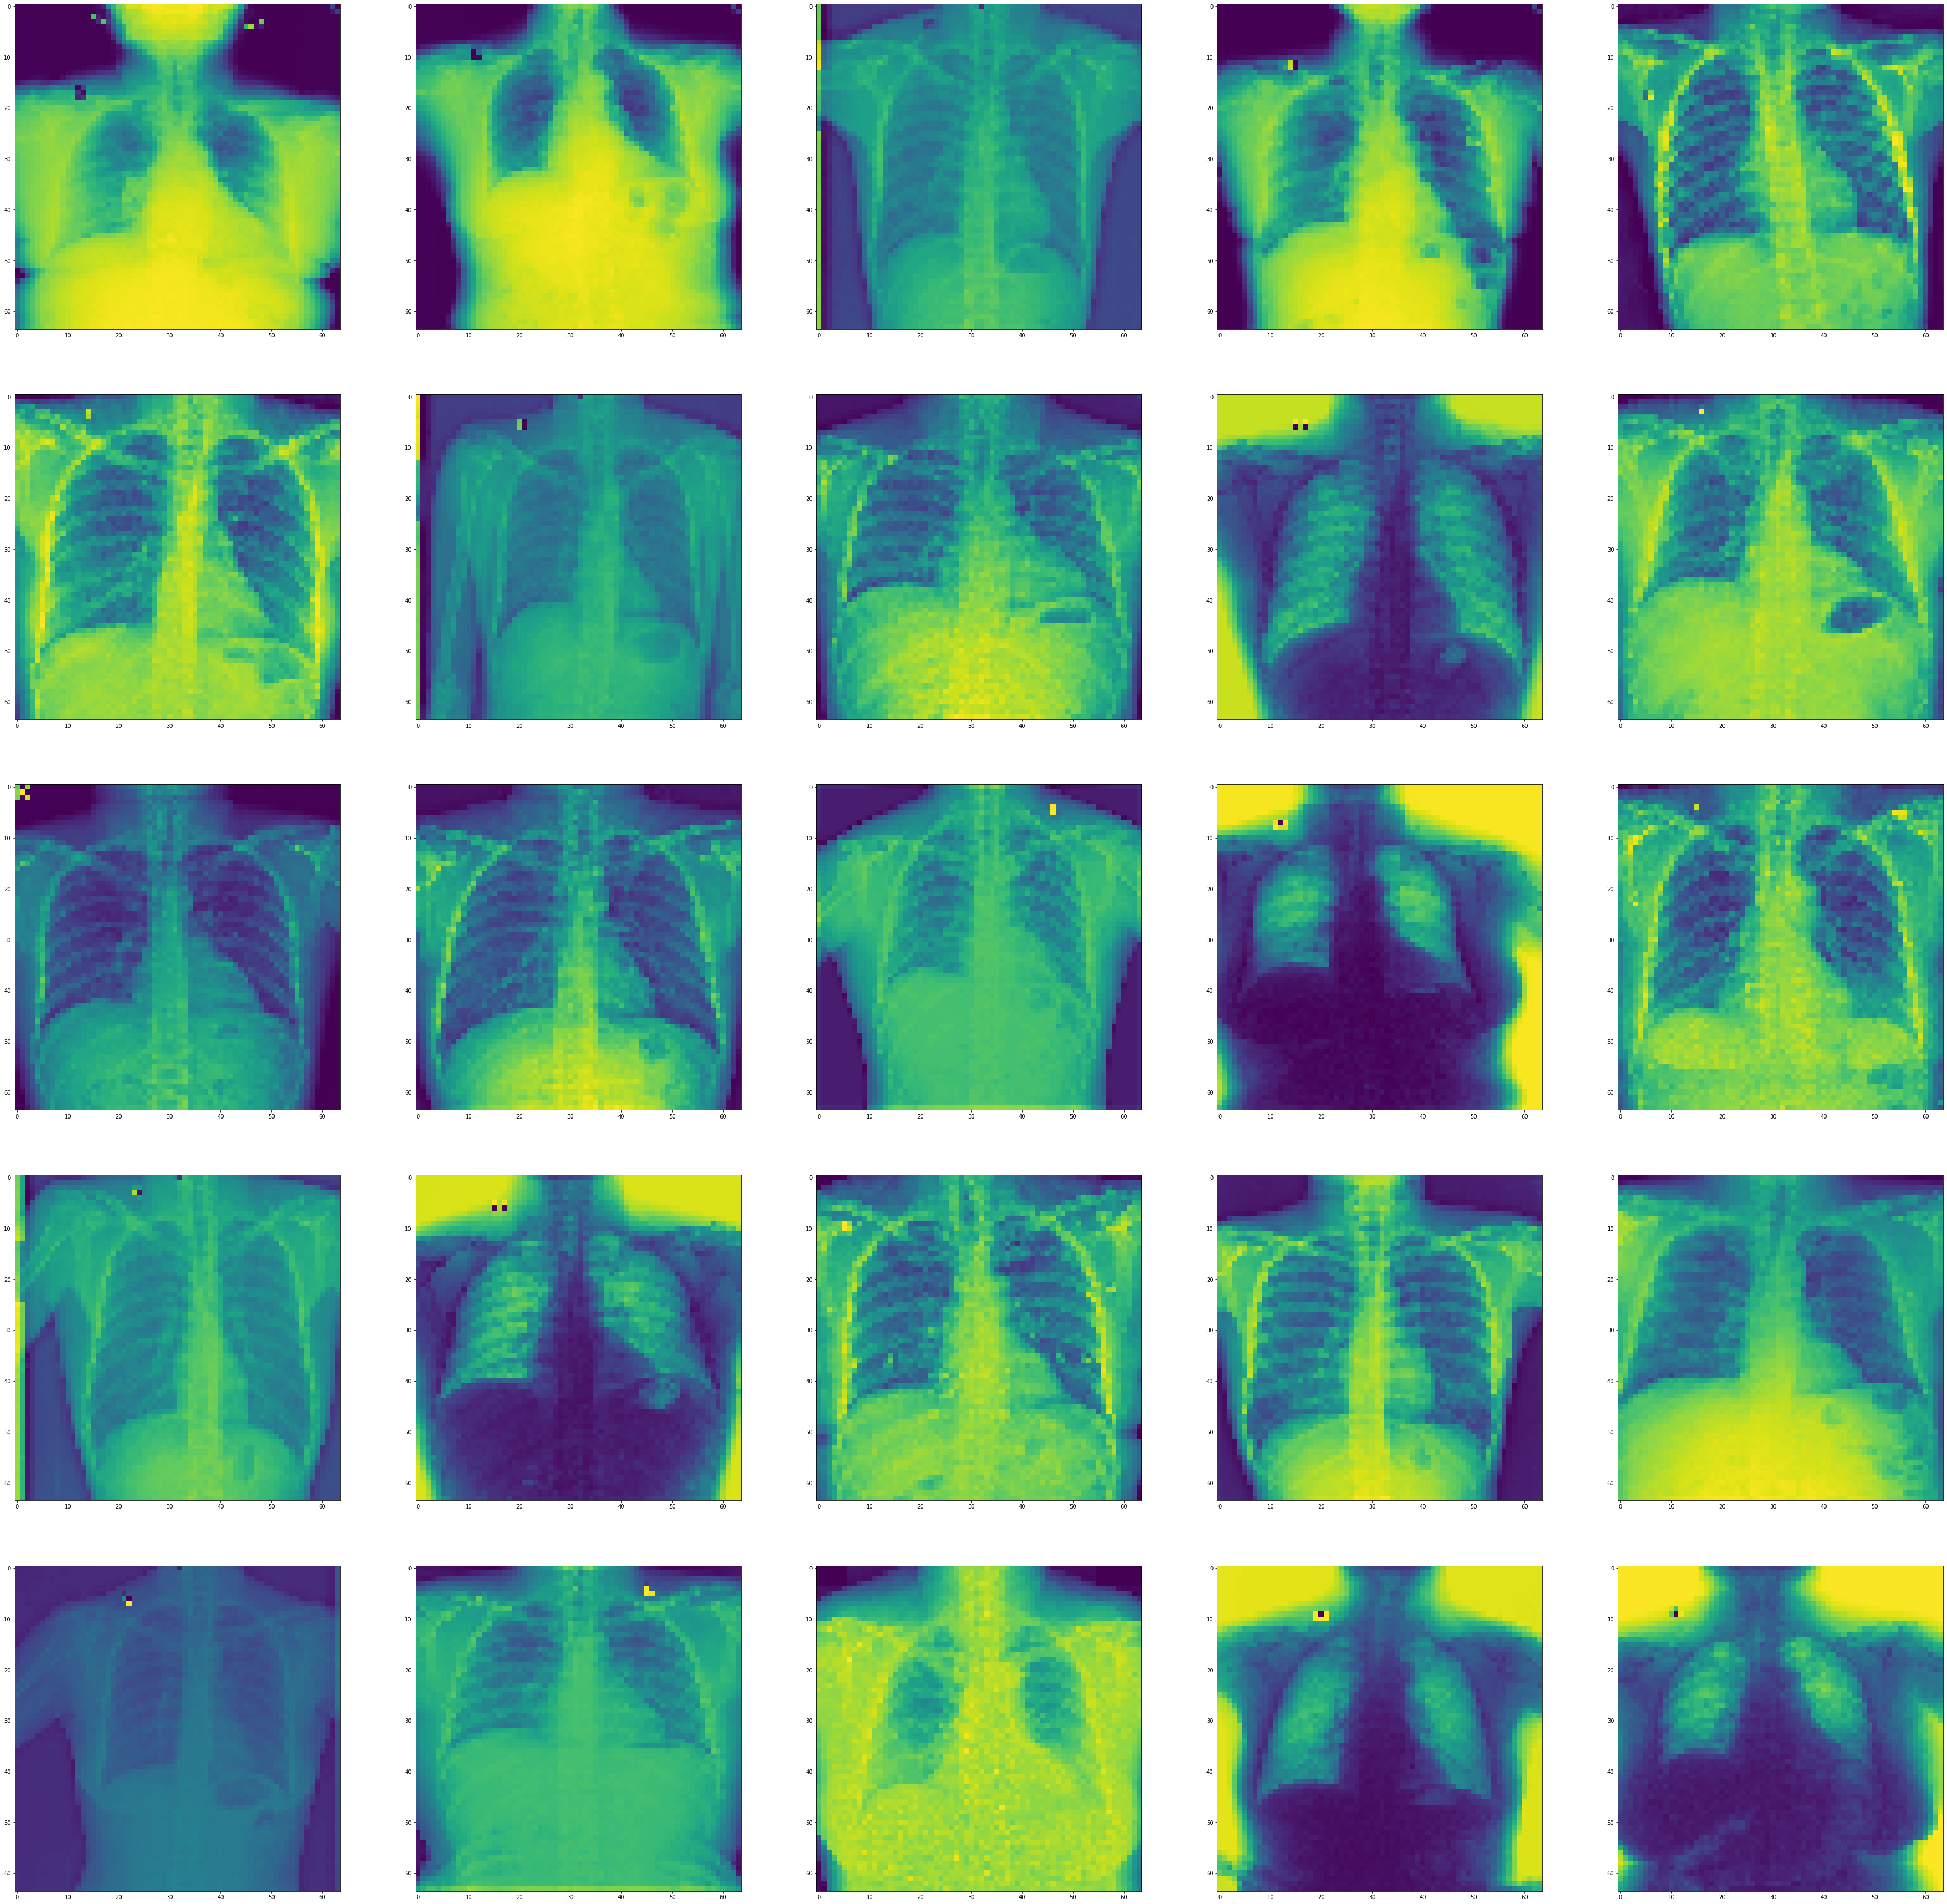

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,5, figsize=(64,64))
for i,ax in enumerate(axes.flat):
    ax.imshow(images[i])

In [3]:
# reshape labels
labels = sum(labels.values.tolist(),[])
labels = np.array(labels)
labels

array([0, 0, 0, ..., 0, 2, 0])

In [27]:
import collections
collections.Counter(labels)

Counter({0: 10506, 1: 2372, 2: 382})

# Split Dataset 

In [4]:
# Split dataset
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42, shuffle=True)

# Let test dataset size be 20%
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1, shuffle=True)

# Let training dataset and validation dataset size be 60% and 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [5]:
X_train.shape

(7956, 64, 64, 1)

In [6]:
# occur the occurance of each number in y_train
import collections
collections.Counter(y_train)

Counter({0: 6270, 1: 1460, 2: 226})

# Data augmentation on training dataset

In [7]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                         height_shift_range=0.1, shear_range=0.15, 
                         zoom_range=0.1, channel_shift_range=10, 
                         horizontal_flip=False)

In [8]:
# get the index of 1 and 2 in y_train
index_1 = np.where(y_train == 1) 
index_2 = np.where(y_train == 2) 

### Increase pictures with label 1

In [9]:
image_1 = images[index_1]
image_1.shape

(1460, 64, 64, 1)

In [10]:
aug_iter_1 = gen.flow(image_1)

In [11]:
# numbers of generate images = numbers of label 0 - numbers of label 1
num_gen_1 = collections.Counter(y_train)[0] - collections.Counter(y_train)[1]

#generate image
aug_images_1 = [next(aug_iter_1)[0].astype(np.uint8) for i in range(num_gen_1)]

In [12]:
#append X_train with aug_image_1
X_data = []
for i in range(X_train.shape[0]):
    X_data.append(X_train[i])
for i in range(num_gen_1):
    X_data.append(aug_images_1[i])

In [13]:
np.shape(X_data)

(12766, 64, 64, 1)

In [14]:
# append y_train with [1]
for i in range(num_gen_1):
    y_train = np.append(y_train, 1)
y_train.shape

(12766,)

In [15]:
collections.Counter(y_train)

Counter({0: 6270, 1: 6270, 2: 226})

In [16]:
# use same methods to create image 2
image_2 = images[index_2]
aug_iter_2 = gen.flow(image_2)

# numbers of generate images
num_gen_2 = collections.Counter(y_train)[0] - collections.Counter(y_train)[2]

#generate image
aug_images_2 = [next(aug_iter_2)[0].astype(np.uint8) for i in range(num_gen_2)]

#append X_train with aug_image_2

for i in range(num_gen_2):
    X_data.append(aug_images_2[i])

# append y_train with [2]
for i in range(num_gen_2):
    y_train = np.append(y_train, 2) 

In [17]:
np.shape(X_data)

(18810, 64, 64, 1)

In [18]:
collections.Counter(y_train)

Counter({0: 6270, 1: 6270, 2: 6270})

In [19]:
X_train = np.array(X_data)
y_train = y_train

# Using CNN to train the dataset

In [20]:
# keras imports for the dataset and building our neural network
# from keras.datasets import mnist
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
# from keras.utils import np_utils

# to calculate accuracy
from sklearn.metrics import accuracy_score

# loading the dataset
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

# building the input vector from the 64x64 pixels
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_val = X_val.reshape(X_val.shape[0], 64, 64, 1)
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_val /= 255

# # one-hot encoding using keras' numpy-related utilities

# print("Shape before one-hot encoding: ", y_train.shape)
# Y_train = np_utils.to_categorical(y_train)
# Y_test = np_utils.to_categorical(y_test)
# print("Shape after one-hot encoding: ", Y_train.shape)

# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(64,64,1)))
model.add(MaxPool2D(pool_size=(1,1)))
model.add(Dropout(0.25)) # use dropout to avoid overfit

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(100, activation='relu'))

# output layer
model.add(Dense(10, activation='softmax'))

# compiling the sequential model
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# early stopping 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# training the model 
epochs= 100
history = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
147/147 [==============================] - 58s 389ms/step - loss: 2.7722 - accuracy: 0.4204 - val_loss: 0.7088 - val_accuracy: 0.7221
Epoch 2/100
147/147 [==============================] - 56s 379ms/step - loss: 0.7688 - accuracy: 0.6309 - val_loss: 0.4722 - val_accuracy: 0.8318
Epoch 3/100
147/147 [==============================] - 55s 373ms/step - loss: 0.6847 - accuracy: 0.6781 - val_loss: 0.4730 - val_accuracy: 0.8311
Epoch 4/100
147/147 [==============================] - 55s 374ms/step - loss: 0.6340 - accuracy: 0.7059 - val_loss: 0.5049 - val_accuracy: 0.8115
Epoch 5/100
147/147 [==============================] - 55s 377ms/step - loss: 0.5818 - accuracy: 0.7368 - val_loss: 0.4759 - val_accuracy: 0.8277
Epoch 6/100
147/147 [==============================] - 55s 373ms/step - loss: 0.5477 - accuracy: 0.7577 - val_loss: 0.4576 - val_accuracy: 0.8375
Epoch 7/100
147/147 [==============================] - 56s 382ms/step - loss: 0.5195 - accuracy: 0.7690 - val_loss: 0.4964 -

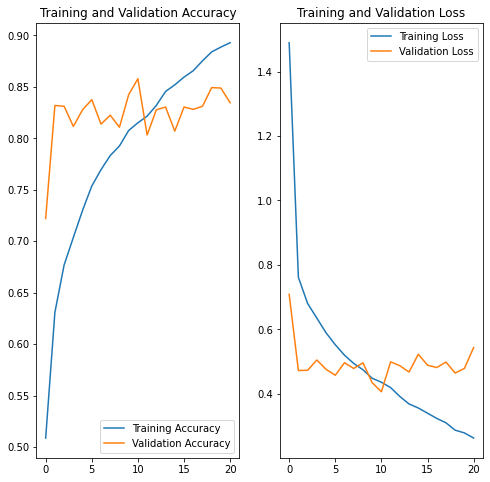

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(21)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
from sklearn import metrics

# True values
y_true = y_test
# Predicted values
pred = model.predict(X_test, verbose=0)
y_pred = np.argmax(pred, axis=-1)

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[1523  483  105]
 [ 136  304   15]
 [  34   48    4]]
              precision    recall  f1-score   support

           0      0.900     0.721     0.801      2111
           1      0.364     0.668     0.471       455
           2      0.032     0.047     0.038        86

    accuracy                          0.690      2652
   macro avg      0.432     0.479     0.437      2652
weighted avg      0.780     0.690     0.719      2652



# Add one extra conv layer

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
# from keras.utils import np_utils

# to calculate accuracy
from sklearn.metrics import accuracy_score

# building a linear stack of layers with the sequential model
model_1 = Sequential()

# convolutional layer
model_1.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(64,64,1)))
model_1.add(MaxPool2D(pool_size=(1,1)))
model_1.add(Dropout(0.25)) # use dropout to avoid overfit

# one extra convolutional layer
model_1.add(Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(64,64,1)))
model_1.add(MaxPool2D(pool_size=(1,1)))
model_1.add(Dropout(0.25)) # use dropout to avoid overfit

# flatten output of conv
model_1.add(Flatten())

# hidden layer
model_1.add(Dense(100, activation='relu'))

# output layer
model_1.add(Dense(10, activation='softmax'))

# compiling the sequential model
model_1.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# early stopping 
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# training the model 
epochs= 100
history_1 = model_1.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val), callbacks=early_stopping_cb)

Epoch 1/100
147/147 [==============================] - 161s 1s/step - loss: 1.5015 - accuracy: 0.3521 - val_loss: 0.7427 - val_accuracy: 0.6776
Epoch 2/100
147/147 [==============================] - 158s 1s/step - loss: 0.8848 - accuracy: 0.5475 - val_loss: 0.5596 - val_accuracy: 0.8073
Epoch 3/100
147/147 [==============================] - 156s 1s/step - loss: 0.8032 - accuracy: 0.6053 - val_loss: 0.5533 - val_accuracy: 0.7952
Epoch 4/100
147/147 [==============================] - 155s 1s/step - loss: 0.7352 - accuracy: 0.6443 - val_loss: 0.4771 - val_accuracy: 0.8326
Epoch 5/100
147/147 [==============================] - 159s 1s/step - loss: 0.6932 - accuracy: 0.6631 - val_loss: 0.4822 - val_accuracy: 0.8228
Epoch 6/100
147/147 [==============================] - 158s 1s/step - loss: 0.6292 - accuracy: 0.6986 - val_loss: 0.5659 - val_accuracy: 0.7922
Epoch 7/100
147/147 [==============================] - 157s 1s/step - loss: 0.5788 - accuracy: 0.7328 - val_loss: 0.5389 - val_accuracy:

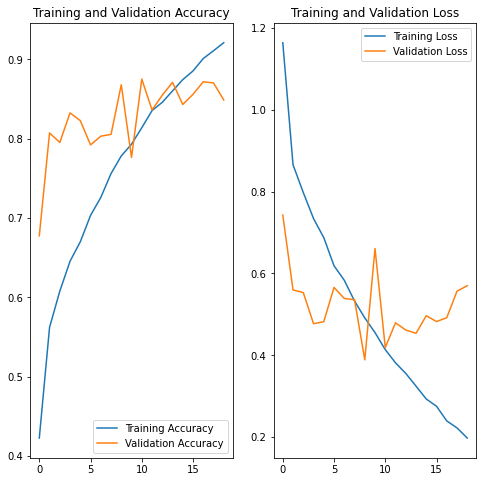

In [25]:
import matplotlib.pyplot as plt
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']


loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
from sklearn import metrics

# True values
y_true = y_test
# Predicted values
pred = model_1.predict(X_test, verbose=0)
y_pred = np.argmax(pred, axis=-1)

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[1949   69   93]
 [ 200  218   37]
 [  49   30    7]]
              precision    recall  f1-score   support

           0      0.887     0.923     0.905      2111
           1      0.688     0.479     0.565       455
           2      0.051     0.081     0.063        86

    accuracy                          0.820      2652
   macro avg      0.542     0.495     0.511      2652
weighted avg      0.825     0.820     0.819      2652



# Kaggle 

In [28]:
# Load dataset
dataset = np.load('datasets/ps4_kaggle_images.npy')

In [31]:
# predicted values
predicted = model_1.predict(dataset, verbose=0)
predicted_values = np.argmax(predicted, axis=-1)

In [32]:
predicted_values

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0,
       2, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1,
       2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 2,
       0, 0, 1, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2])

In [33]:
import csv
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Predicted"])
    
    i = 0
    for ele in predicted_values:
        
        writer.writerow([i, ele])
        
        i += 1